# Introduction

This file is meant to provide a diagnosis for one or more patients using the models trained with the DARWIN dataset. The output will be the classification and the explanations given by each model for each patient and it will be saved in the specified folder in the <b><i>input_settings_darwin.json</i></b> in the <i>configs</i> folder.

Note: This code should take less than 10 minutes to run.

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lime.lime_tabular
import shap
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from DatasetAnalysis import DatasetAnalysis
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
import pickle
import dill
import os
import plotly.io as pio

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Setup

In [2]:
config_file = open("configs\\input_settings_darwin.json")
config_vars = json.load(config_file)
config_file.close()


models_dir = config_vars["models_dir"]
input_dir = config_vars["input_dir"]
output_dir = config_vars["output_dir"]

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [3]:
config_file = open("configs\\visual_config.json")
visual_vars = json.load(config_file)
config_file.close()

shap_colors_neg = visual_vars["shap_colors"]["negative"]
shap_colors_pos = visual_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = visual_vars["title_font_size"]
label_size = visual_vars["labels_font_size"]

green_color = tuple([x/255 for x in visual_vars["green_colors"]["c2"]])

# Get Patient Data

In [4]:
diagnosis_data = pd.read_csv(f"{input_dir}/feature_names.csv", header=0)

for file in os.listdir(input_dir):
    if file != "feature_names.csv":
        patient_info = pd.read_csv(f"{input_dir}/{file}", header=None, names=diagnosis_data.columns)
        patient_info = patient_info.rename(index={0: file[:-4]})
        if len(diagnosis_data) == 0:
            diagnosis_data = patient_info
        else:
            diagnosis_data = pd.concat([diagnosis_data, patient_info])

# Classification

In [5]:
diagnosis_data

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
IDPatient0,2130.0,0.000010,369.403342,183.193104,1756.0,8159.0,0.556879,0.164502,276.298223,0.090408,...,163.065803,0.113905,0.019860,4.206746,1.613522,123.0,67945.0,1465.843329,230184.7154,181220.0
IDPatient1,7770.0,0.000007,252.920870,241.011868,2076.0,5683.0,0.498263,0.193680,246.966369,0.084725,...,286.213565,0.231913,0.020821,6.278983,3.277159,58.0,33560.0,1840.851162,144392.4464,63130.0


In [6]:
perf_analysis = PerformanceAnalysis()

## <i>Logistic Regression</i> (LR)

In [7]:
filename="DARWIN_LR.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lr_clf = pickle.load(file)

#### Local

##### <i>Local Model-Agnostic Explanations</i> (LIME)

In [8]:
filename = "DARWIN_LIME.dill"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lime_explainer = dill.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [9]:
filename = "DARWIN_LR_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    lr_shap_explainer = pickle.load(file)

## <i>Random Forest</i> (RF)

In [10]:
filename="DARWIN_RF.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    rf_clf = pickle.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [11]:
filename = "DARWIN_RF_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    rf_shap_explainer = pickle.load(file)

## <i> Support Vector Machines</i> (SVM)

In [12]:
filename="DARWIN_SVM.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    svm_clf = pickle.load(file)

##### <i>SHapley Additive exPlanations</i> (SHAP)

In [13]:
filename = "DARWIN_SVM_SHAP.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    svm_shap_explainer = pickle.load(file)

## <i>Explainable Boosting Machine</i> (EBM)

In [14]:
filename="DARWIN_EBM_no_interactions.pkl"
with open(f"{models_dir}/{filename}", 'rb') as file:
    ebm_clf = pickle.load(file)

## Predictions & Explanations

In [15]:
latex_str = "PID & LR & RF & SVM & EBM \\\ \n"

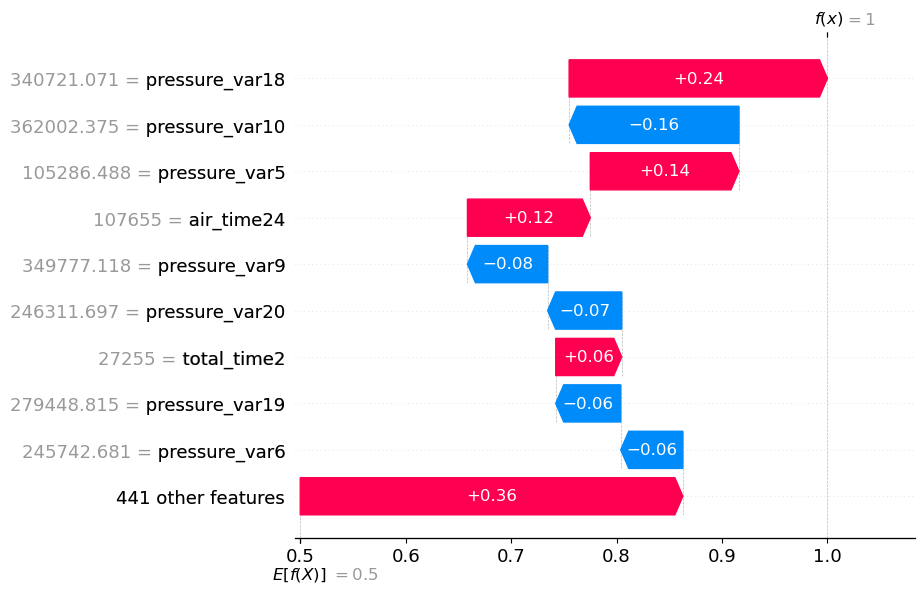

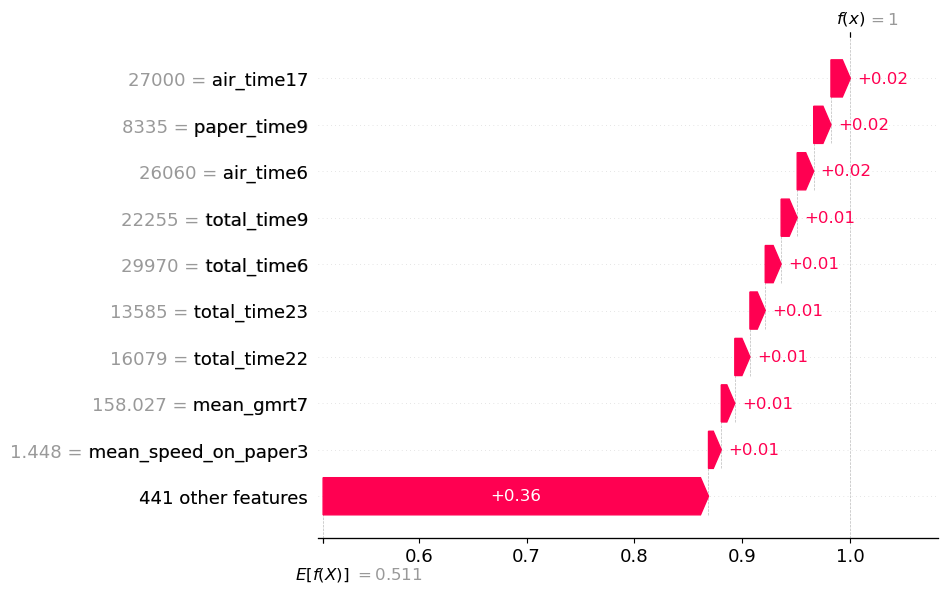

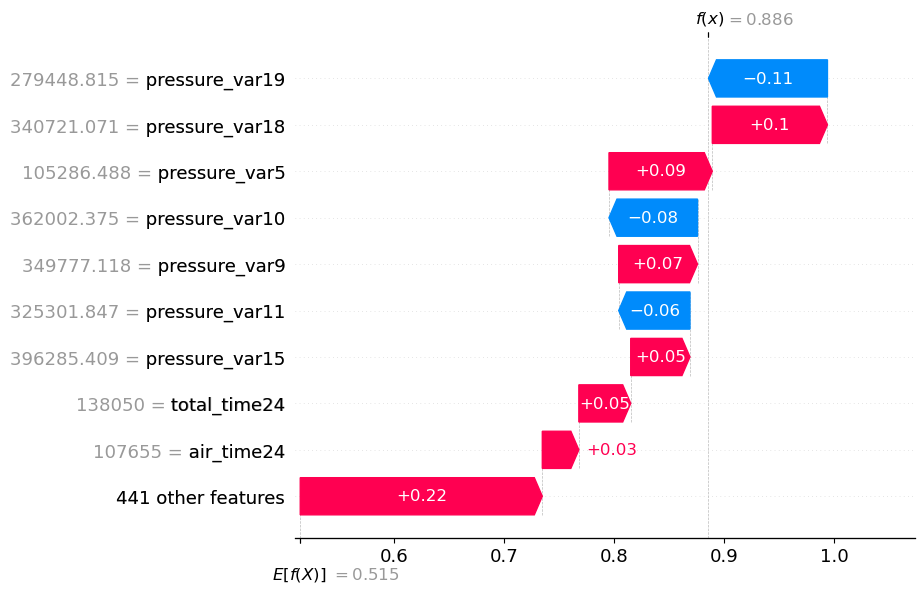

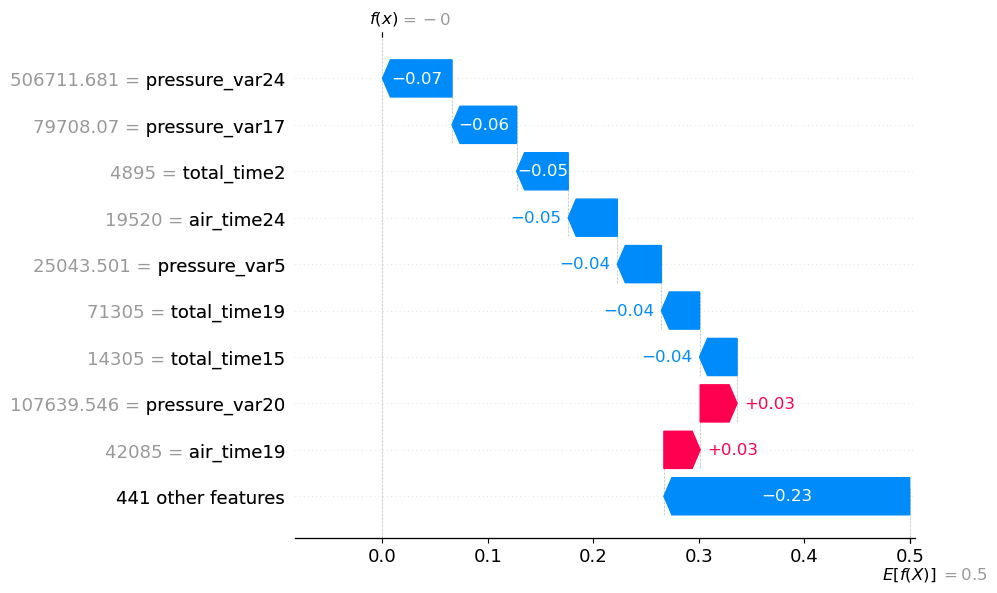

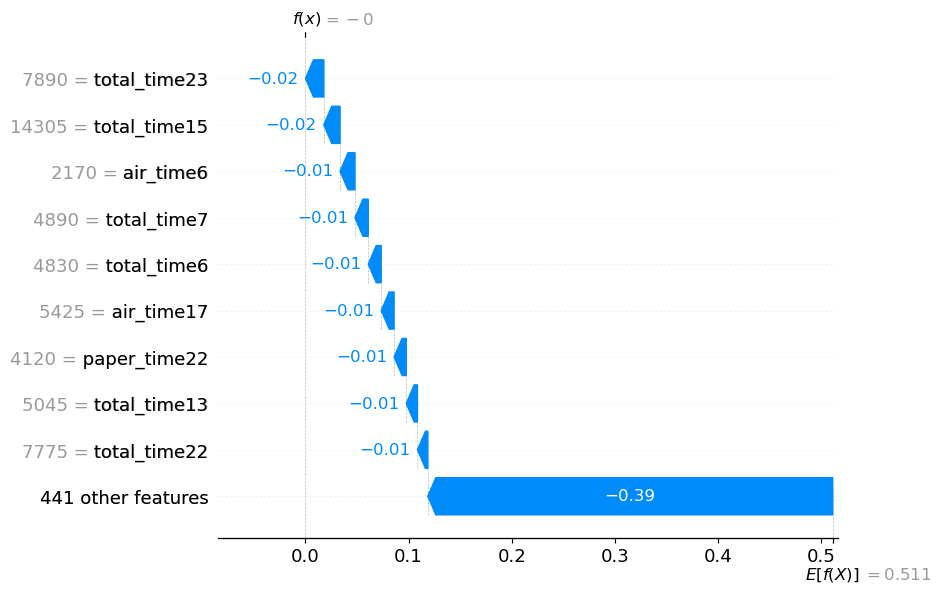

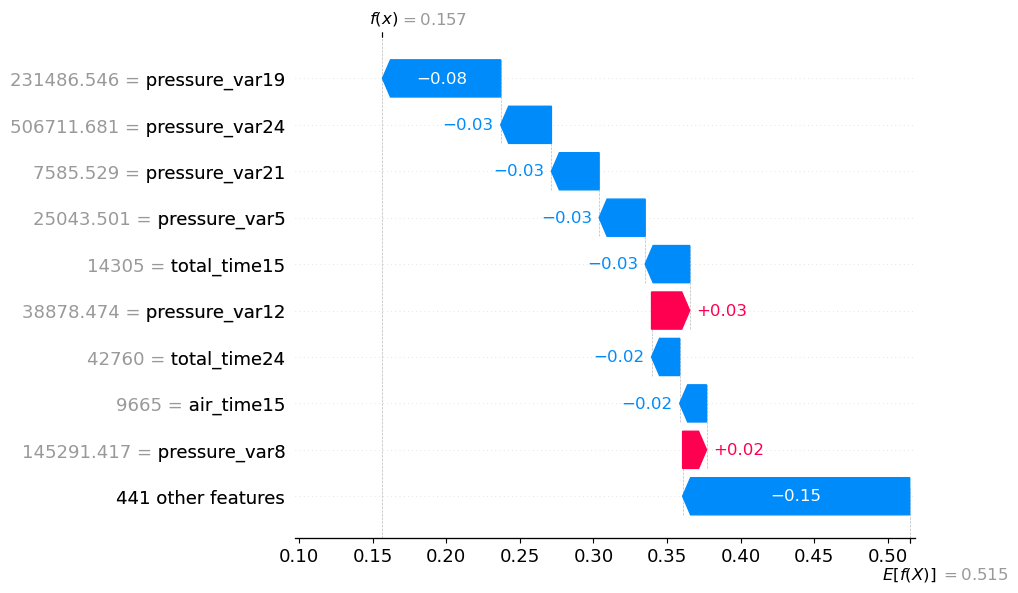

In [16]:
for index, row in diagnosis_data.iterrows():
    
    row_pd = pd.DataFrame([row.to_numpy()], columns=diagnosis_data.columns)
    row_np = row.to_numpy()
    
    ## Predictions
    pred_lr = lr_clf.predict([row_np])
    pred_rf = rf_clf.predict([row_np])
    pred_svm = svm_clf.predict([row_np])
    pred_ebm = ebm_clf.predict([row_np])
    
    latex_row = f"{index} & {pred_lr[0]} & {pred_rf[0]} & {pred_svm[0]} & {pred_ebm[0]} \\\ \n"
    latex_str += latex_row
    
    
    ## LIME
    lr_lime_explanation = lime_explainer.explain_instance(row_np, lr_clf.predict_proba)
    lr_lime_explanation.save_to_file(f"{output_dir}/lr_lime_{index}.html")
    rf_lime_explanation = lime_explainer.explain_instance(row_np, rf_clf.predict_proba)
    rf_lime_explanation.save_to_file(f"{output_dir}/rf_lime_{index}.html")
    svm_lime_explanation = lime_explainer.explain_instance(row_np, svm_clf.predict_proba)
    svm_lime_explanation.save_to_file(f"{output_dir}/svm_lime_{index}.html")


    ## SHAP
    lr_shap_loc_values = np.array(lr_shap_explainer.shap_values(row))
    rf_shap_loc_values = np.array(rf_shap_explainer.shap_values(row))
    svm_shap_loc_values = np.array(svm_shap_explainer.shap_values(row))


    explanations = [shap.Explanation(lr_shap_loc_values[1, :], lr_shap_explainer.expected_value[1], data=row),
                shap.Explanation(rf_shap_loc_values[1, :], rf_shap_explainer.expected_value[1], data=row),
                shap.Explanation(svm_shap_loc_values[1, :], svm_shap_explainer.expected_value[1], data=row)]


    shap.plots.waterfall(explanations[0], show=False)
    plt.gcf().savefig(f"{output_dir}/lr_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    shap.plots.waterfall(explanations[1], show=False)
    plt.gcf().savefig(f"{output_dir}/rf_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    shap.plots.waterfall(explanations[2], show=False)
    plt.gcf().savefig(f"{output_dir}/svm_shap_local_{index}.png", bbox_inches="tight")
    plt.show()
    
    
    ## EBM
    ebm_local = ebm_clf.explain_local(row_pd)
    plot = ebm_local.visualize(0) 
    pio.write_image(plot, f"{output_dir}/ebm_local_{index}_no_interactions.png", format='png', width=1280, height=720)
    

In [17]:
with open(f"{output_dir}/patients_predictions.txt", "w") as text_file:
    print(latex_str, file=text_file)